In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
image_height = 64
image_width = 64

datagen = ImageDataGenerator(
    rescale=1./255,        
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.01,
    zoom_range=0.01,         
    horizontal_flip=False,
    vertical_flip=False,
)

train_generator = datagen.flow_from_directory(
    'data/train',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='sparse',
    color_mode='grayscale'
)

validation_generator = datagen.flow_from_directory(
    'data/validation',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='sparse',
    color_mode='grayscale'
)

Found 132884 images belonging to 84 classes.
Found 33221 images belonging to 84 classes.


In [2]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential(name='model_bng')

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, 1)))
# model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
    
model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
    
model.add(Flatten())

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))

model.add(Dense(train_generator.num_classes, activation='softmax'))  

model.compile(
    optimizer=SGD(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
    
model.summary()

Model: "model_bng"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 62, 62, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 29, 29, 64)        256       
 chNormalization)                                                
                                                         

In [3]:
import warnings
from tensorflow.keras.callbacks import ModelCheckpoint

warnings.filterwarnings('ignore', category=UserWarning, module='keras')

checkpoint = ModelCheckpoint(
    'model_bng_weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    patience=10,
    verbose=1
)

In [4]:
epochs = 100

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

Epoch 1/100
4153/4153 [==============================] - ETA: 0s - loss: 4.1586 - accuracy: 0.1211
Epoch 1: val_accuracy improved from -inf to 0.35071, saving model to model_bng_weights.h5
4153/4153 [==============================] - 217s 52ms/step - loss: 4.1586 - accuracy: 0.1211 - val_loss: 3.1471 - val_accuracy: 0.3507
Epoch 2/100
4153/4153 [==============================] - ETA: 0s - loss: 3.1451 - accuracy: 0.2963
Epoch 2: val_accuracy improved from 0.35071 to 0.54255, saving model to model_bng_weights.h5
4153/4153 [==============================] - 217s 52ms/step - loss: 3.1451 - accuracy: 0.2963 - val_loss: 2.2520 - val_accuracy: 0.5425
Epoch 3/100
4152/4153 [============================>.] - ETA: 0s - loss: 2.5984 - accuracy: 0.4020
Epoch 3: val_accuracy improved from 0.54255 to 0.62289, saving model to model_bng_weights.h5
4153/4153 [==============================] - 222s 53ms/step - loss: 2.5986 - accuracy: 0.4020 - val_loss: 1.8345 - val_accuracy: 0.6229
Epoch 4/100
4152/41

In [5]:
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history_bng.csv', index=False)

history_df

,loss,accuracy,val_loss,val_accuracy
0,4.158570,0.121068,3.147148,0.350712
1,3.145055,0.296281,2.251971,0.542548
2,2.598594,0.401967,1.834487,0.622889
3,2.285222,0.468378,1.603214,0.669546
4,2.072634,0.514577,1.458924,0.697300
...,...,...,...,...
95,0.576967,0.862113,0.483175,0.892658
96,0.575401,0.861902,0.485247,0.892417
97,0.572747,0.862730,0.480280,0.894494
98,0.569802,0.863324,0.486906,0.892959


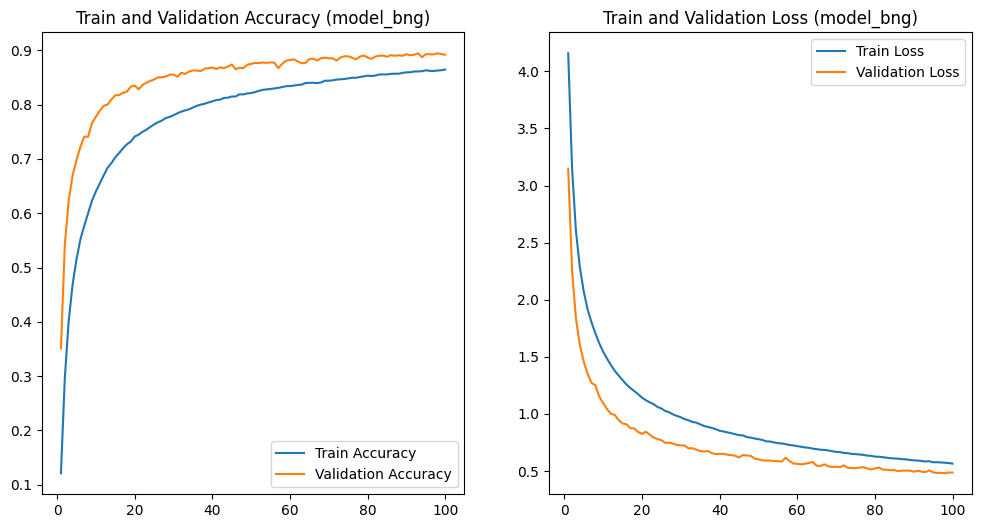

In [6]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Train and Validation Accuracy (model_bng)')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Train and Validation Loss (model_bng)')
plt.legend()

plt.show()

In [7]:
from sklearn.metrics import classification_report

predictions = model.predict(validation_generator)

predicted_labels = predictions.argmax(axis=1)
true_labels = validation_generator.classes

class_names = list(validation_generator.class_indices.keys())

report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

1039/1039 [==============================] - 25s 24ms/step
              precision    recall  f1-score   support

           1       0.01      0.01      0.01       391
          10       0.01      0.01      0.01       391
          11       0.01      0.01      0.01       393
          12       0.02      0.02      0.02       416
          13       0.02      0.02      0.02       369
          14       0.01      0.01      0.01       383
          15       0.01      0.01      0.01       388
          16       0.01      0.01      0.01       376
          17       0.01      0.01      0.01       385
          18       0.01      0.01      0.01       384
          19       0.01      0.01      0.01       409
           2       0.02      0.02      0.02       418
          20       0.02      0.02      0.02       425
          21       0.02      0.02      0.02       419
          22       0.01      0.01      0.01       389
          23       0.01      0.01      0.01       352
          24       0.0